In [1]:
%load_ext autoreload
%autoreload 2

In [155]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions
from src.models import model_mine
from src.submission import generate_predictions

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [149]:
(X_train, y_train), _, (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 128338.14it/s]


In [150]:
X_train.shape, X_train.values.shape

((30160,), (30160,))

### Compute the classes weights because our dataset is largely unbalanced

In [118]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

### Create an embedding matrix for our vocabulary

In [142]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
# Unknown words: 1303

print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 1303
8.84% of our vocabulary are unknown words to the embedding matrix


In [123]:
import autocorrect

ModuleNotFoundError: No module named 'autocorrect'

In [143]:
unknown_words

{'angru',
 'gdmg',
 'masterbuated',
 'whonis',
 'flyingcow',
 'hereaftr',
 'pottypiece',
 'lamakaan',
 'pulihora',
 'annpying',
 'tjhell',
 'histetical',
 'cheatet',
 'bueatyfull',
 'nerdyaddy',
 'nsmer',
 'sngry',
 'd=<',
 'ainvy',
 'listion',
 'bchfhmnvcffgghhjkhhggfvb',
 'planings',
 'suffrerring',
 'mrsing',
 'abilitity',
 'misuderstanding',
 'pakaa',
 'vizagite',
 'doesnst',
 'cheppali',
 'mishane',
 'sharaddha',
 'comsidered',
 'chooes',
 'rndi',
 'dyrtdd',
 'seand',
 'bthng',
 'asips',
 'srabani',
 'ambulans',
 'nabr',
 'unabe',
 'chapathi',
 'sabudana',
 'cubieboard',
 'refrral',
 'cigaratte',
 'alrays',
 'raceguram',
 'dalrs',
 'assked',
 'your1',
 '♀️',
 'worlsly',
 'aditeya',
 'meenukkum',
 'hmmk',
 'fakme',
 '=‑d',
 'barthdey',
 'sreshta',
 'picter',
 'oghh',
 'dsrling',
 'kalpita',
 'splitvilla',
 'frendzone',
 'exaple',
 'esshh',
 'frndzone',
 'boilnes',
 'hveli',
 'vahicle',
 'publicuty',
 'wishkey',
 'rellyname',
 'udaals',
 'gubbi',
 'kickley',
 'ownner',
 'confuserd',

### Transforming our sequences of words to indexes

In [151]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)

X_train.shape

(30160, 163)

In [152]:
y_train = to_categorical(y_train, 4)
(x_trn, y_trn), (x_val, y_val), (x_tst, y_tst) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')
print('validation_test set: ' + str(len(x_tst)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 24128 samples
validation set: 3016 samples
validation_test set: 3016 samples
x_train: (24128, 163)
y_train: (24128, 4)


### Training

In [153]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 163, 300)          4424400   
_________________________________________________________________
dropout_7 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 163, 300)          541200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 163, 300)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 48900)             0         
__________

In [163]:
checkpointer = ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1)

In [154]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=3, class_weight=cls_weights, callbacks=[checkpointer])

Train on 24128 samples, validate on 3016 samples
Epoch 1/3
24128/24128 [==============================] - 417s 17ms/step - loss: 0.7434 - acc: 0.7127 - val_loss: 0.5028 - val_acc: 0.8229
Epoch 2/3
24128/24128 [==============================] - 414s 17ms/step - loss: 0.4985 - acc: 0.8150 - val_loss: 0.4339 - val_acc: 0.8568
Epoch 3/3
24128/24128 [==============================] - 414s 17ms/step - loss: 0.4183 - acc: 0.8481 - val_loss: 0.3804 - val_acc: 0.8578


In [161]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=3, class_weight=cls_weights, callbacks=[checkpointer])

Train on 24128 samples, validate on 3016 samples
Epoch 1/3
24128/24128 [==============================] - 410s 17ms/step - loss: 0.2695 - acc: 0.9016 - val_loss: 0.3013 - val_acc: 0.8962
Epoch 2/3
24128/24128 [==============================] - 414s 17ms/step - loss: 0.2503 - acc: 0.9087 - val_loss: 0.3186 - val_acc: 0.8932
Epoch 3/3
24128/24128 [==============================] - 412s 17ms/step - loss: 0.2277 - acc: 0.9164 - val_loss: 0.3202 - val_acc: 0.8962


### Evaluating our model

#### Validation set

True Positives per class :  [ 491.  375.  462. 1350.]
False Positives per class :  [ 78.  53.  46. 161.]
False Negatives per class :  [ 87.  48.  77. 126.]

Class angry : Precision : 0.863, Recall : 0.849, F1 : 0.856
Class happy : Precision : 0.876, Recall : 0.887, F1 : 0.881
Class sad : Precision : 0.909, Recall : 0.857, F1 : 0.883

Ignoring the Others class, Macro Precision : 0.8828, Macro Recall : 0.8644, Macro F1 : 0.8735
Ignoring the Others class, Micro TP : 1328, FP : 177, FN : 212

Accuracy : 0.8879, Micro Precision : 0.8824, Micro Recall : 0.8623, Micro F1 : 0.8722


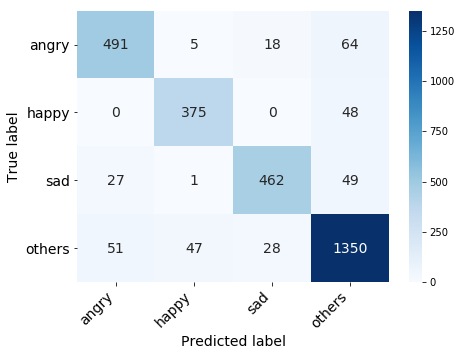

In [115]:
y_pred_val = get_predictions(model, x_val, y_val) # Last Best

True Positives per class :  [ 511.  373.  475. 1344.]
False Positives per class :  [104.  45.  47. 117.]
False Negatives per class :  [ 47.  62.  64. 140.]

Class angry : Precision : 0.831, Recall : 0.916, F1 : 0.871
Class happy : Precision : 0.892, Recall : 0.857, F1 : 0.875
Class sad : Precision : 0.910, Recall : 0.881, F1 : 0.895

Ignoring the Others class, Macro Precision : 0.8777, Macro Recall : 0.8848, Macro F1 : 0.8813
Ignoring the Others class, Micro TP : 1359, FP : 196, FN : 173

Accuracy : 0.8962, Micro Precision : 0.8740, Micro Recall : 0.8871, Micro F1 : 0.8805


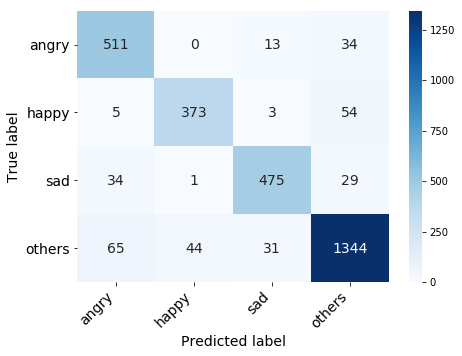

In [165]:
y_pred_val = get_predictions(model, x_val, y_val)

#### Test set

True Positives per class :  [ 482.  359.  497. 1348.]
False Positives per class :  [ 72.  60.  40. 158.]
False Negatives per class :  [ 69.  48.  83. 130.]

Class angry : Precision : 0.870, Recall : 0.875, F1 : 0.872
Class happy : Precision : 0.857, Recall : 0.882, F1 : 0.869
Class sad : Precision : 0.926, Recall : 0.857, F1 : 0.890

Ignoring the Others class, Macro Precision : 0.8841, Macro Recall : 0.8712, Macro F1 : 0.8776
Ignoring the Others class, Micro TP : 1338, FP : 172, FN : 200

Accuracy : 0.8906, Micro Precision : 0.8861, Micro Recall : 0.8700, Micro F1 : 0.8780


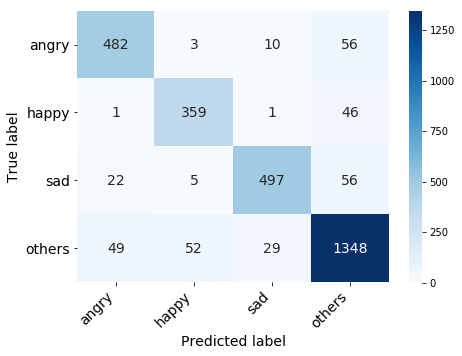

In [112]:
y_pred_tst = get_predictions(model, x_tst, y_tst) # Last Best

True Positives per class :  [ 508.  377.  507. 1331.]
False Positives per class :  [91. 49. 54. 99.]
False Negatives per class :  [ 36.  65.  44. 148.]

Class angry : Precision : 0.848, Recall : 0.934, F1 : 0.889
Class happy : Precision : 0.885, Recall : 0.853, F1 : 0.869
Class sad : Precision : 0.904, Recall : 0.920, F1 : 0.912

Ignoring the Others class, Macro Precision : 0.8789, Macro Recall : 0.9023, Macro F1 : 0.8905
Ignoring the Others class, Micro TP : 1392, FP : 194, FN : 145

Accuracy : 0.9029, Micro Precision : 0.8777, Micro Recall : 0.9057, Micro F1 : 0.8915


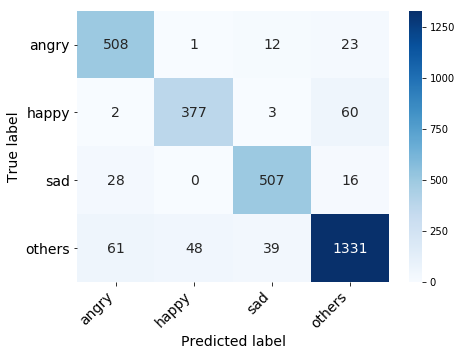

In [164]:
y_pred_tst = get_predictions(model, x_tst, y_tst)

In [114]:
model.save('pickles/models/tst_acc_0.89-tst_f1_0.878.h5')

### Generating a submission file

In [166]:
generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:01<00:00, 2726.38it/s]


Generating Predictions...
Done. Wrote submission.txt file at project's root
